# Notebook 02: Ingesta y Procesamiento Meteorológico

**Objetivo:** Consolidar los múltiples archivos CSV de temperatura horaria (DMC) en una única serie temporal continua, limpiarla y generar métricas diarias (Mínima, Máxima y Promedio).

**Estrategia de Calidad:**
1. **Fuente Única:** Utilizaremos solo los archivos de `Temperatura` (horaria). Las métricas `Max` y `Min` se derivarán matemáticamente de aquí para evitar inconsistencias entre archivos de origen distintos.
2. **Imputación:** Se usará interpolación lineal para rellenar pequeños vacíos de datos (horas perdidas).
3. **Resampling:** Se reducirá la granularidad de Hora -> Día para alinear con el análisis macro.

**Input:** Múltiples archivos en `data/raw/` con patrón `*_Temperatura_.csv`.
**Output:** `data/processed/clima_diario_limpio.csv`

In [1]:
import pandas as pd
import numpy as np
import glob
import os

# --- CONFIGURACIÓN DE RUTAS ---
RAW_DIR = os.path.join('..', 'data', 'raw', 'meteorologia')
PROCESSED_DIR = os.path.join('..', 'data', 'processed')
OUTPUT_FILE = os.path.join(PROCESSED_DIR, 'clima_diario_limpio.csv')

# Asegurar que existe el directorio de salida
os.makedirs(PROCESSED_DIR, exist_ok=True)

## 1. Ingesta Masiva Automática
Usamos la librería `glob` para encontrar todos los archivos de temperatura, sin importar el año. Esto hace que el script sea a prueba de futuro (si agregas 2026, funcionará solo).

In [2]:
print(">>> Buscando archivos de temperatura...")

# Buscamos cualquier archivo que contenga 'Temperatura' en el nombre
# Esto asume el formato: 330020_2015_Temperatura_.csv
patron_archivos = os.path.join(RAW_DIR, '*_Temperatura_*.csv')
archivos = sorted(glob.glob(patron_archivos))

print(f"Archivos encontrados: {len(archivos)}")

lista_dfs = []

for archivo in archivos:
    try:
        # DMC usa punto y coma como separador y no tiene cabeceras estándar a veces
        # Leemos solo las primeras columnas relevantes
        df_temp = pd.read_csv(archivo, sep=';', header=None, usecols=[0, 1, 2], names=['codigo', 'momento', 'temp_raw'])
        lista_dfs.append(df_temp)
        # print(f"  -> Cargado: {os.path.basename(archivo)}") # Descomentar para debug
    except Exception as e:
        print(f"  ❌ Error cargando {os.path.basename(archivo)}: {e}")

if not lista_dfs:
    raise ValueError("No se encontraron archivos de temperatura. Verifica la ruta data/raw/")

# Consolidar en un solo DataFrame gigante
df_full = pd.concat(lista_dfs, ignore_index=True)
print(f"\n>>> Total de registros horarios crudos: {len(df_full)}")

>>> Buscando archivos de temperatura...
Archivos encontrados: 11

>>> Total de registros horarios crudos: 94396


## 2. Limpieza y Conversión
Convertimos la columna de tiempo a `datetime` y la temperatura a numérico. Los errores se convierten en `NaN` para ser tratados después.

In [3]:
print(">>> Limpiando tipos de datos...")

# 1. Convertir fecha
df_full['fecha_hora'] = pd.to_datetime(df_full['momento'], errors='coerce')

# 2. Convertir temperatura (forzar numérico)
df_full['temperatura'] = pd.to_numeric(df_full['temp_raw'], errors='coerce')

# 3. Eliminar filas donde la fecha sea NaT (errores de lectura)
df_clean = df_full.dropna(subset=['fecha_hora']).copy()

# 4. Ordenar cronológicamente
df_clean = df_clean.sort_values('fecha_hora').reset_index(drop=True)

# 5. Establecer índice temporal para operaciones de series de tiempo
df_clean.set_index('fecha_hora', inplace=True)

print(f"Registros válidos: {len(df_clean)}")
print(df_clean[['temperatura']].head())

>>> Limpiando tipos de datos...
Registros válidos: 94385
                     temperatura
fecha_hora                      
2015-01-01 00:00:00         21.3
2015-01-01 01:00:00         19.4
2015-01-01 02:00:00         17.9
2015-01-01 03:00:00         17.1
2015-01-01 04:00:00         17.0


C:\Users\corre\AppData\Local\Temp\ipykernel_20020\1599988382.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_full['fecha_hora'] = pd.to_datetime(df_full['momento'], errors='coerce')


## 3. Imputación de Datos Faltantes
En clima, si falta un dato de las 3:00 PM, es mejor interpolar (promediar entre las 2:00 y 4:00 PM) que ponerlo en 0.

In [4]:
# Contar nulos antes
nulos_antes = df_clean['temperatura'].isna().sum()

print(f">>> Imputando {nulos_antes} valores faltantes por interpolación lineal...")

# Interpolación lineal basada en el tiempo
df_clean['temperatura'] = df_clean['temperatura'].interpolate(method='time')

# Si quedan nulos al inicio o final, usamos backfill/ffill
df_clean['temperatura'] = df_clean['temperatura'].bfill().ffill()

print("Imputación completa.")

>>> Imputando 9 valores faltantes por interpolación lineal...
Imputación completa.


## 4. Agregación Diaria (Resampling)
Transformamos los datos horarios en un resumen diario. Esto simplifica el análisis y elimina el ruido de la variación horaria para el modelo mensual posterior.

In [5]:
print(">>> Generando métricas diarias...")

# Agrupamos por Día ('D') y calculamos métricas clave
df_diario = df_clean['temperatura'].resample('D').agg(
    temp_min='min',
    temp_max='max',
    temp_prom='mean'
).reset_index()

# Redondear a 2 decimales
df_diario = df_diario.round(2)

# Renombrar columna de fecha para que coincida con el estándar del proyecto
df_diario.rename(columns={'fecha_hora': 'fecha'}, inplace=True)

# Validación
print(f"Días procesados: {len(df_diario)}")
display(df_diario.head())

# --- FILTRO DE CALIDAD ---
# Eliminar días vacíos si es que existen huecos gigantes en la data original
df_diario = df_diario.dropna()
print(f"Días finales válidos: {len(df_diario)}")

>>> Generando métricas diarias...
Días procesados: 3940


,fecha,temp_min,temp_max,temp_prom
0,2015-01-01,15.1,29.8,21.15
1,2015-01-02,12.7,31.5,22.41
2,2015-01-03,12.4,32.8,22.99
3,2015-01-04,14.1,33.3,23.95
4,2015-01-05,14.4,31.3,22.85


Días finales válidos: 3940


## 5. Visualización de Control y Guardado
Verificamos visualmente que no haya "saltos" extraños o valores de 0 absolutos que indiquen errores.

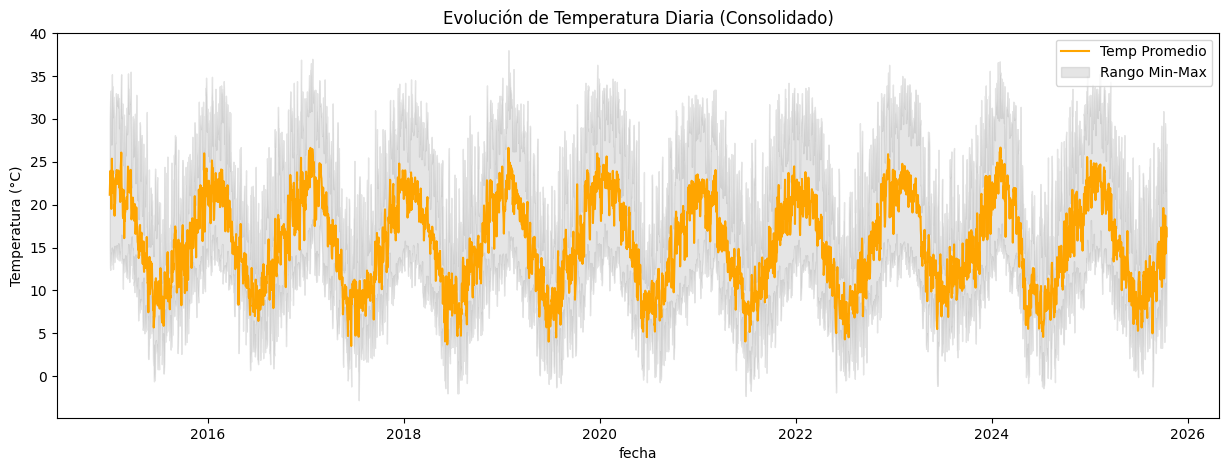

>>> Guardando archivo maestro en: ..\data\processed\clima_diario_limpio.csv
✅ ÉXITO. Datos meteorológicos procesados.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_diario, x='fecha', y='temp_prom', color='orange', label='Temp Promedio')
plt.fill_between(df_diario['fecha'], df_diario['temp_min'], df_diario['temp_max'], alpha=0.2, color='gray', label='Rango Min-Max')
plt.title("Evolución de Temperatura Diaria (Consolidado)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()

# --- GUARDADO FINAL ---
print(f">>> Guardando archivo maestro en: {OUTPUT_FILE}")
df_diario.to_csv(OUTPUT_FILE, index=False)
print("✅ ÉXITO. Datos meteorológicos procesados.")